In [1]:
from cluster import *
from utils import *
from wavelet import *

import os
import numpy as np

In [2]:
# Retrieve folders for transgenic strains

transgenics = os.listdir('../CoBar-Dataset')
transgenics.remove('PR') # Control

In [3]:
raw_pretarsi_data, raw_metadata, _, n_trial_data = get_data_per_fly_per_xp(transgenics)

MDN - Data dimension: (28770, 70)
MDN - Metadata dimension: (28770, 6)
MDN: 12 trials
SS01049 - Data dimension: (26385, 70)
SS01049 - Metadata dimension: (26385, 6)
SS01049: 11 trials
SS01054 - Data dimension: (31162, 70)
SS01054 - Metadata dimension: (31162, 6)
SS01054: 13 trials
SS01540 - Data dimension: (26361, 70)
SS01540 - Metadata dimension: (26361, 6)
SS01540: 11 trials
SS02111 - Data dimension: (26396, 70)
SS02111 - Metadata dimension: (26396, 6)
SS02111: 11 trials
SS02279 - Data dimension: (28776, 70)
SS02279 - Metadata dimension: (28776, 6)
SS02279: 12 trials
SS02377 - Data dimension: (28764, 70)
SS02377 - Metadata dimension: (28764, 6)
SS02377: 12 trials
SS02608 - Data dimension: (28740, 70)
SS02608 - Metadata dimension: (28740, 6)
SS02608: 12 trials
SS02617 - Data dimension: (26355, 70)
SS02617 - Metadata dimension: (26355, 6)
SS02617: 11 trials


In [4]:
def runPipeline(raw_pretarsi_data, raw_metadata, n_trial_data, average=False, groupByFly = False, decimate = False):
    stim_data = findStimulationData(raw_pretarsi_data, raw_metadata)
    print(f'Stimulation data - number of flies: {len(stim_data)}')
    print(f'Dimension of an observation {stim_data[next(iter(stim_data))].shape} \n')
    
    if average:
        stim_data = averageStimDataPerStrain(stim_data, n_trial_data)
        print('Averaging fly data for each strain: Done')
        print(f'Stimulation data observations after averaging: {len(stim_data)}')
        print(f'Dimension of an observation {stim_data[next(iter(stim_data))].shape} \n')
    
    wavelet_data = findWavelets(stim_data)
    print('Wavelet transform: Done')
    print(f'Dimension of an observation {wavelet_data[next(iter(wavelet_data))].shape}')
    
    wavelet_array, min_nFrames = dict2array(wavelet_data, nCoords=40, groupByFly=groupByFly, decimate=decimate)
    print(f'Conversion to array - data shape: {wavelet_array.shape} \n')
    
    embedded_array = runTSNE(wavelet_array, groupByFly = groupByFly)
    np.save('embedded.npy', embedded_array)
    print(f'TSNE - data shape: {embedded_array.shape}')
    
    if decimate:
        min_nFrames = int(min_nFrames/2)
    
    classes, strains, unique_classes = buildColorMap(n_trial_data, min_nFrames, average=average, groupByFly=groupByFly)

    ova_classes, ranges = buildOVAColorMaps(n_trial_data, classes, min_nFrames, groupByFly=groupByFly)

    buildJointPlot(embedded_array, n_trial_data, classes, strains, unique_classes)

    buildStrainJointPlots(embedded_array, n_trial_data, ova_classes, strains, ranges)

Stimulation data - number of flies: 105
Dimension of an observation (716, 12) 

Wavelet transform: Done
Dimension of an observation (716, 240)
Conversion to array - data shape: (73920, 240) 

TSNE - data shape: (73920, 2)
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
9/9


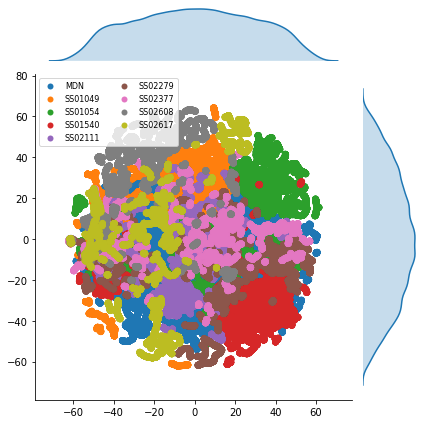

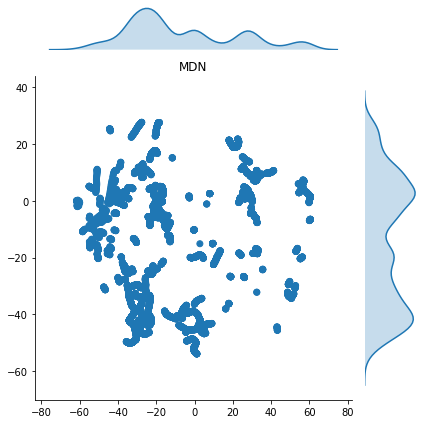

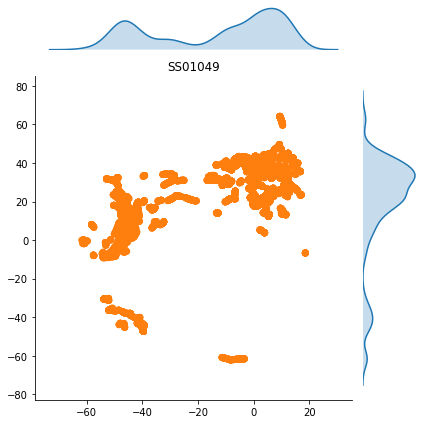

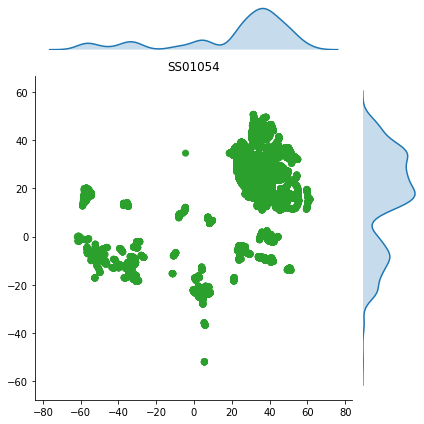

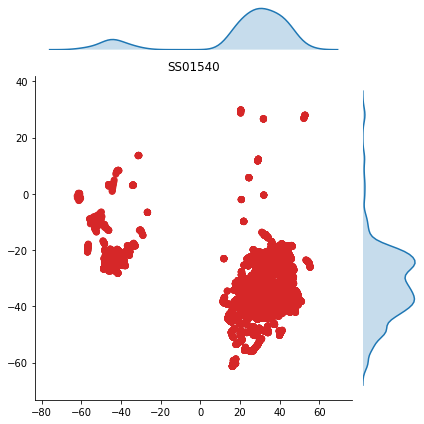

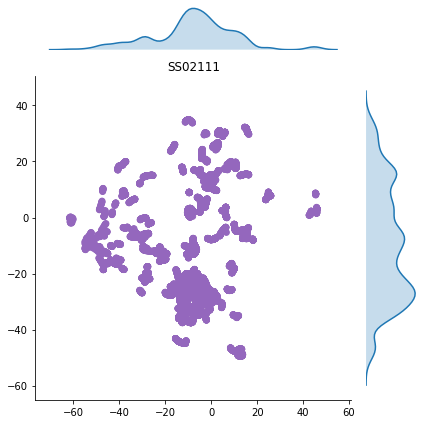

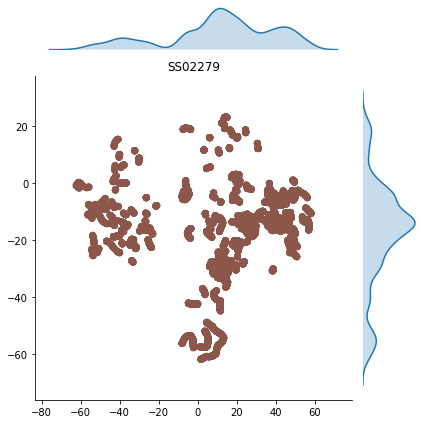

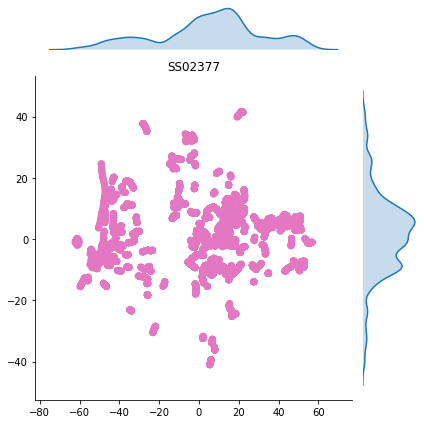

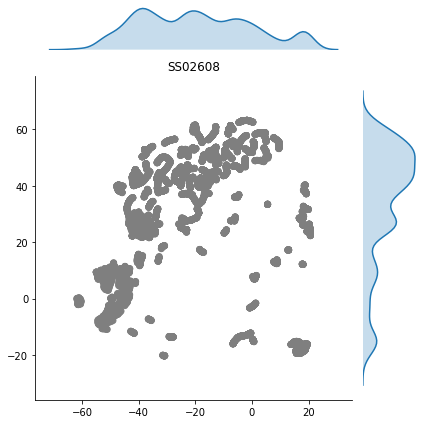

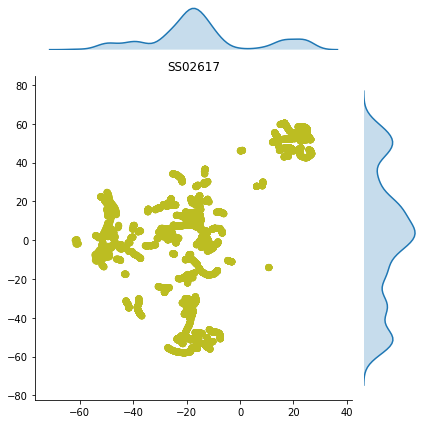

In [5]:
runPipeline(raw_pretarsi_data, raw_metadata, n_trial_data, average=False, groupByFly=False, decimate=False)

In [6]:
embedded_array = np.load('embedded.npy')

In [7]:
min_nFrames = 704

groupByFly = False

average = False

classes, strains, unique_classes = buildColorMap(n_trial_data, min_nFrames, average=average, groupByFly=groupByFly)

AttributeError: 'AxesSubplot' object has no attribute 'ax_joint'

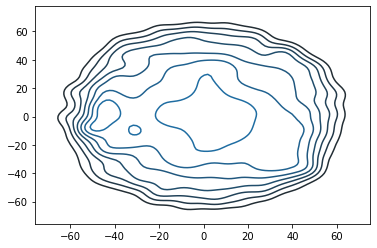

In [9]:
import seaborn as sns
g = sns.kdeplot(embedded_array[:,0], embedded_array[:,1])

#Clear the axes containing the scatter plot
g.ax_joint.cla()
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

# set the current axis to be the joint plot's axis
plt.sca(g.ax_joint)

# plt.scatter takes a 'c' keyword for color
# you can also pass an array of floats and use the 'cmap' keyword to
# convert them into a colormap

sc = plt.scatter(embedded_array[:,0], embedded_array[:,1], c = classes, label = strains)

lp = lambda i: plt.plot([], color = unique_classes[i], mec="none",
                        label=list(n_trial_data.keys())[i], ls="", marker="o")[0]

handles = [lp(i) for i in np.arange(len(np.unique(strains)))]
plt.legend(handles=handles, ncol=2, prop={'size': 8})
plt.tight_layout()